# My Model Save & Load
---
## Easy, but Important!

### Keras Update

In [1]:
!pip install keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.0 MB/s eta 0:00:00


### Library Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras

from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from keras.callbacks import EarlyStopping

## Data Loading

In [3]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 살펴보기

id = 5956
다음 그림은 숫자 4 입니다.


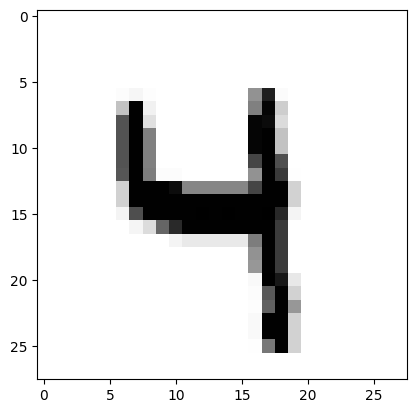

In [5]:
id = np.random.randint(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id], cmap='Greys')
plt.show()

## Data Preprocessing

* Data split
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_x, val_x, train_y, val_y =\
    train_test_split(train_x, train_y, test_size=0.2, random_state=2024)

In [8]:
train_x.shape, train_y.shape

((48000, 28, 28), (48000,))

* Scaling
    - min-max scaling

In [9]:
train_x = train_x / 255.
val_x = val_x / 255.
test_x = test_x / 255.

In [10]:
train_x.max(), train_x.min()

(1.0, 0.0)

* One-Hot Encoding

In [11]:
from keras.utils import to_categorical

In [12]:
train_y = to_categorical(train_y, 10)
val_y = to_categorical(val_y, 10)
test_y = to_categorical(test_y, 10)

* 흑백 정보를 명시하기 위한 reshape

In [13]:
train_x = train_x.reshape((-1, 28, 28, 1))
val_x = val_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))

In [14]:
train_x.shape, train_y.shape

((48000, 28, 28, 1), (48000, 10))

## Modeling : CNN

- 조건
    1. Sequential API, Functiona API 중 택일.
    2. Image Augmentation Layer를 최소 하나 이상 넣을 것! : [공식 문서 참고](https://keras.io/api/layers/preprocessing_layers/)
    3. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    4. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    5. Early Stopping을 사용할 것.

In [15]:
## Sequential API
keras.utils.clear_session()

model = keras.models.Sequential()

model.add( keras.layers.Input(shape=(28,28,1)) )

model.add( keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( keras.layers.MaxPool2D((2,2)) )
model.add( keras.layers.BatchNormalization() )
model.add( keras.layers.Dropout(0.4) )

model.add( keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( keras.layers.MaxPool2D((2,2)) )
model.add( keras.layers.BatchNormalization() )
model.add( keras.layers.Dropout(0.4) )

model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(10, activation='softmax') )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,746 (377.91 KB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

In [16]:
## Functional API
keras.utils.clear_session()

il = keras.layers.Input(shape=(28,28,1))

hl = keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu')(il)
hl = keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.MaxPool2D((2,2))(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.4)(hl)

hl = keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.MaxPool2D((2,2))(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.4)(hl)

hl = keras.layers.Flatten()(hl)
ol = keras.layers.Dense(10, activation='softmax')(hl)

model = keras.models.Model(il, ol)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,746 (377.91 KB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

In [17]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

* Early Stopping

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
es = EarlyStopping('val_loss', 0, 5, 1,
                   restore_best_weights=True
                   )

* **Model Checkpoint**

In [20]:
from keras.callbacks import ModelCheckpoint

In [21]:
mcp = ModelCheckpoint(filepath='./model1.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 | False : 모델 구조 포함하여 저장

* .fit( )

In [22]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y),
                    epochs=10000, verbose=1,
                    callbacks=[es, mcp]
                    )

Epoch 1/10
1486/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8919 - loss: 0.3594
Epoch 1: val_loss improved from inf to 0.10389, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8924 - loss: 0.3576 - val_accuracy: 0.9720 - val_loss: 0.1039
Epoch 2/10
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.0851
Epoch 2: val_loss improved from 0.10389 to 0.04147, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9753 - loss: 0.0850 - val_accuracy: 0.9872 - val_loss: 0.0415
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9814 - loss: 0.0649
Epoch 3: val_loss did not improve from 0.04147
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9814 - loss: 0.0649 - val_accuracy: 0.9810 - val_loss: 0.0721
Epoch 4/10
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0585
Epoch 4: val_loss improved from 0.04147 to 0.03261, saving model to ./model1.ke

In [23]:
performance_test = model.evaluate(test_x, test_y)

print(f'Test Loss: {performance_test[0]:.6f}')
print(f'Test Accuracy: {performance_test[1]*100:.3f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9905 - loss: 0.0308
Test Loss: 0.022662
Test Accuracy: 99.250%


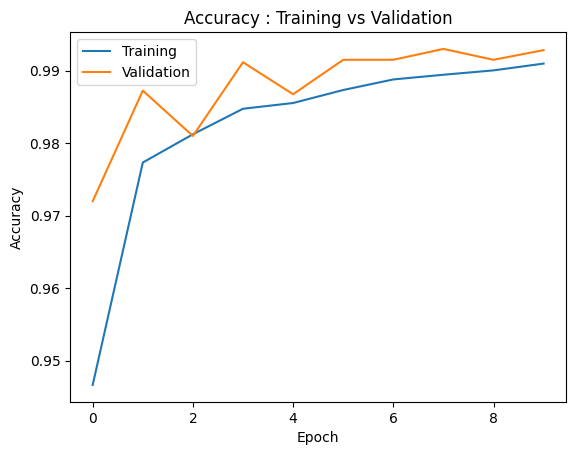

In [24]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

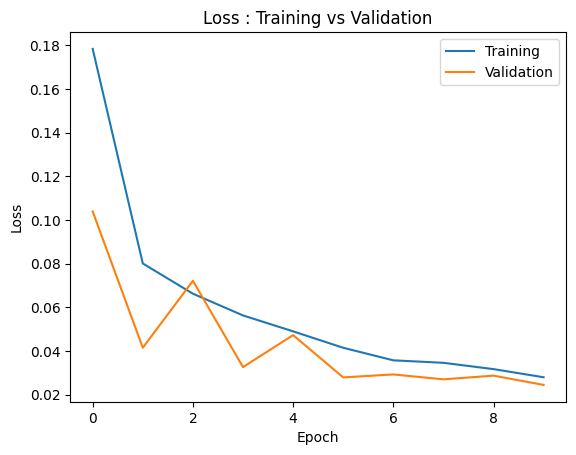

In [25]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## **Model Save & Load**

- .save( )
- .load_model( )

* 모델을 새롭게 저장하여 구조와 가중치 일부를 살펴보자

In [26]:
model.save('./my_first_save.keras')

In [32]:
keras.utils.clear_session()

model3 = keras.saving.load_model('./my_first_save.keras')
model3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,856 (1.11 MB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 193,110 (754.34 KB)

In [28]:
model3.get_weights()[0][0][0]

array([[-0.10119566,  0.08084376,  0.15104967, -0.15694769,  0.03615958,
         0.12660536, -0.12750193, -0.14368519, -0.1354965 , -0.08292318,
         0.04972395,  0.07297504,  0.22818229,  0.04258099, -0.24791914,
         0.06701836, -0.20984237, -0.05281933, -0.31917414, -0.03499657,
        -0.25125977, -0.12260355,  0.2381174 , -0.02533852,  0.15255156,
         0.16140346,  0.2141204 ,  0.03408821,  0.2290093 ,  0.02405383,
         0.15672089, -0.2740937 ]], dtype=float32)

* 학습 과정에서 저장된 모델을 불러와 구조와 가중치 일부를 살펴보자

In [30]:
keras.utils.clear_session()

model = keras.models.load_model('./model1.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,856 (1.11 MB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 193,110 (754.34 KB)

In [31]:
model.get_weights()[0][0][0]

array([[-0.10119566,  0.08084376,  0.15104967, -0.15694769,  0.03615958,
         0.12660536, -0.12750193, -0.14368519, -0.1354965 , -0.08292318,
         0.04972395,  0.07297504,  0.22818229,  0.04258099, -0.24791914,
         0.06701836, -0.20984237, -0.05281933, -0.31917414, -0.03499657,
        -0.25125977, -0.12260355,  0.2381174 , -0.02533852,  0.15255156,
         0.16140346,  0.2141204 ,  0.03408821,  0.2290093 ,  0.02405383,
         0.15672089, -0.2740937 ]], dtype=float32)

* .predict( )

In [33]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN
트레이닝 정확도 : 99.68%
테스트 정확도 : 99.25%


## Visualization

* 실제 데이터 확인

id = 1125
다음 그림은 숫자 8 입니다.
모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
정답입니다


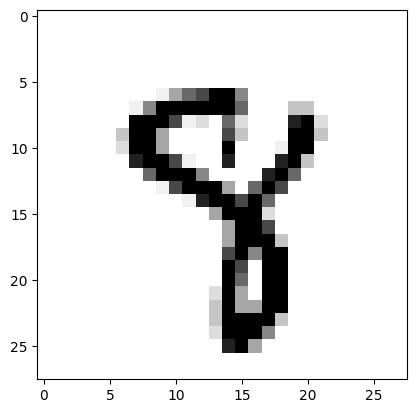

In [34]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = np.random.randint(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

* 틀린 이미지만 확인해보기

id = 5937
다음 그림은 숫자 5 입니다.
모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  0.  0. 93.  0.  6.  0.  0.  0.  0.]
틀렸어요


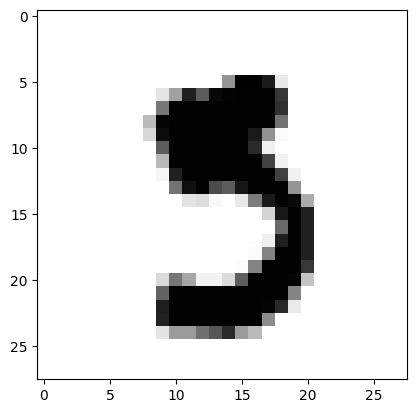

In [35]:
true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[np.random.randint(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

# **내가 만든 손글씨 이미지는 어떻게 판단할까?**
---
## **구글 드라이브에 손글씨 이미지를 업로드!**
###**순서**
1. 그림판으로 숫자를 그려서 저장한다.
2. 구글 드라이브 첫 화면에 my_data 라는 폴더를 만든다.
3. my_data 폴더 안에 my_mnist 폴더를 만든다.
4. my_mnist 폴더 안에 1번 과정에서 만든 이미지를 업로드한다.
5. 30초 정도 기다립시다.
6. 아래의 코드들을 실행해본다.

## Connect Colaboratory with my Google Drive
- Colaboratory와 본인의 구글 드라이브를 연결하는 과정
- 아래 코드를 실행하여 폴더가 올바르게 생성 되었는지 확인

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
!ls

drive  model1.keras  my_first_save.keras  sample_data


In [38]:
!cd /content/drive/MyDrive/my_data; ls

datasets  img1	model1.keras  my_first_save.h5	   my_mnist   MyPjt  transfer
handmade  img2	model.png     my_first_save.keras  my_mnist2  temp


## Load Image
- 업로드 한 이미지 하나를 불러와 확인해본다

In [39]:
import glob
from keras.preprocessing import image

In [40]:
files = glob.glob('/content/drive/MyDrive/my_data/my_mnist/*')
files

['/content/drive/MyDrive/my_data/my_mnist/2_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/6_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_1.png',
 '/content/drive/MyDrive/my_data/my_mnist/2_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/7_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/9_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/8_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/0_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/1_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/3_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/4_2.png',
 '/content/drive/MyDrive/my_data/my_mnist/5_2.png',
 '/content/d

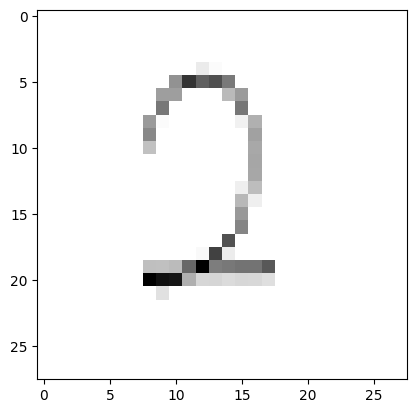

In [41]:
img = image.load_img(files[0], color_mode='grayscale', target_size=(28,28) )
img = image.img_to_array(img)

plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
plt.show()

In [42]:
img = 255-img

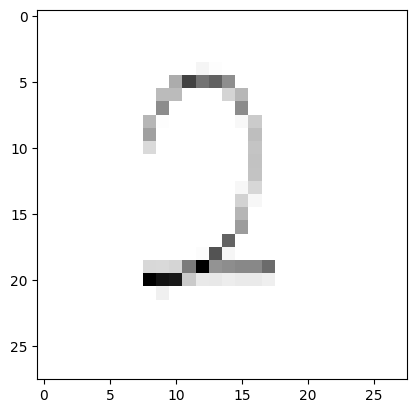

In [43]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [44]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


2

## Load Images
- 업로드 한 이미지 전체를 확인해본다

In [45]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [46]:
images.shape

(50, 28, 28, 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


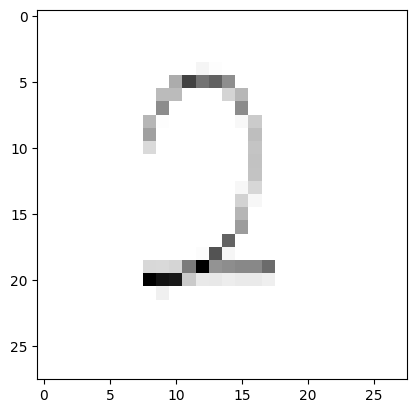

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


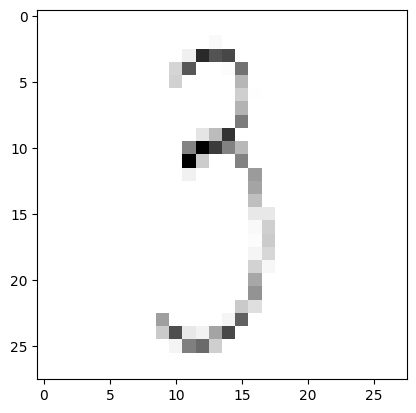

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


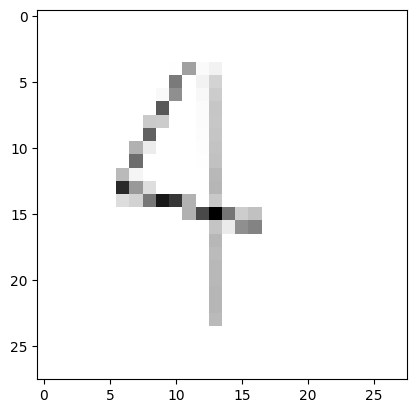

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


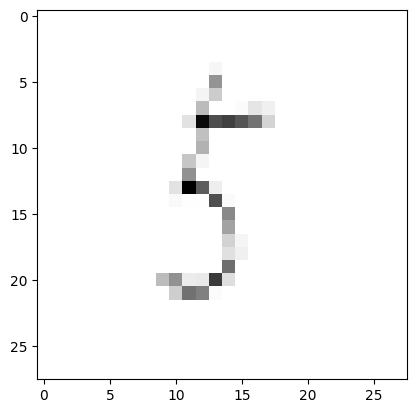

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


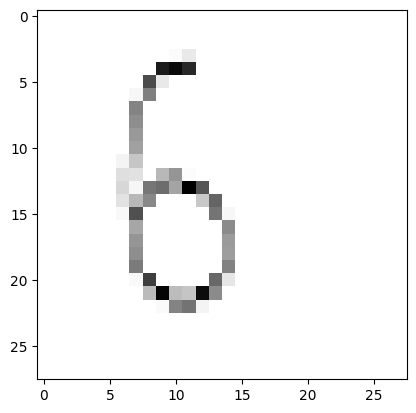

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


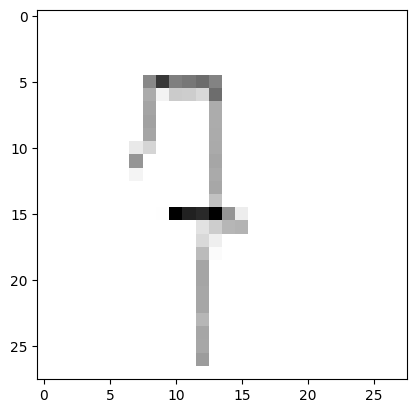

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


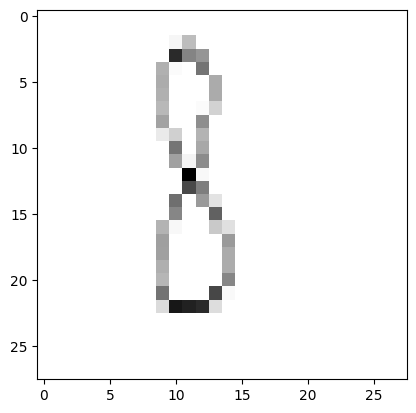

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


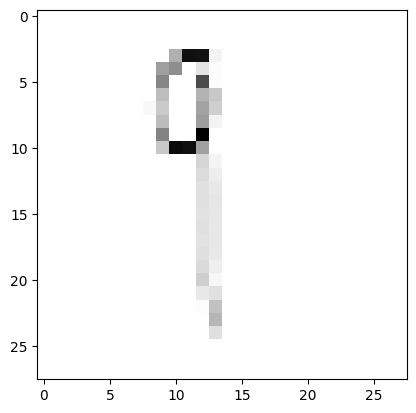

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


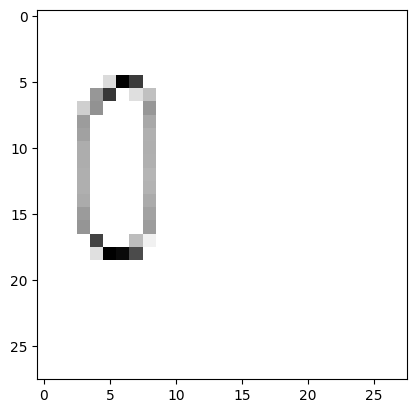

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


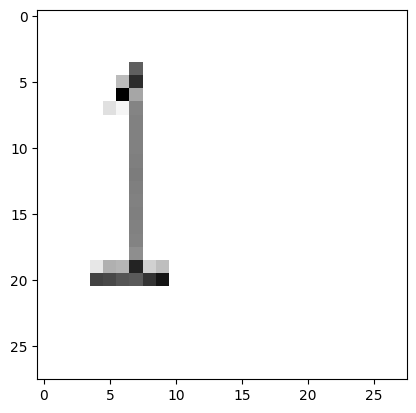

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


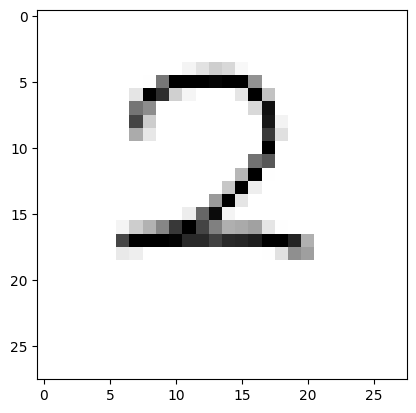

모델의 예측 : 7
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0. 99.  0.  0.]


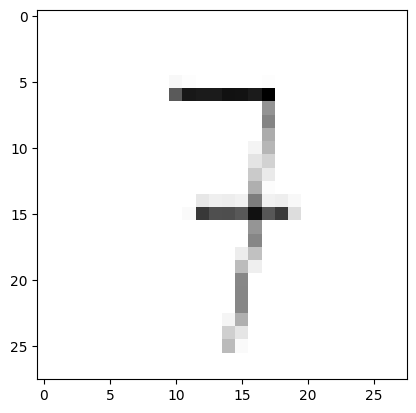

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


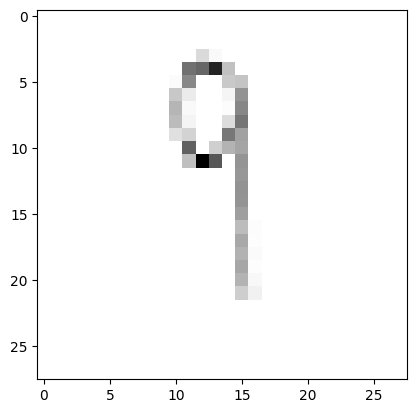

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


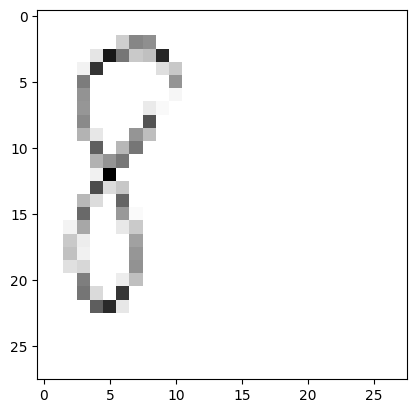

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


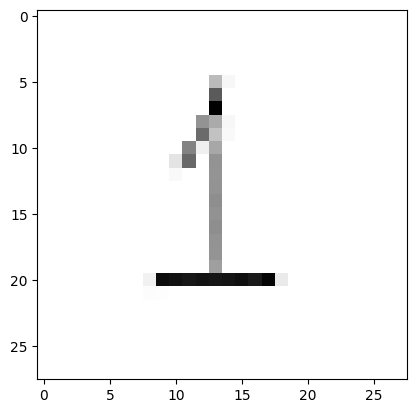

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


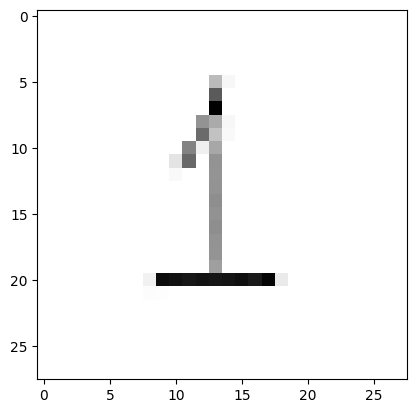

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


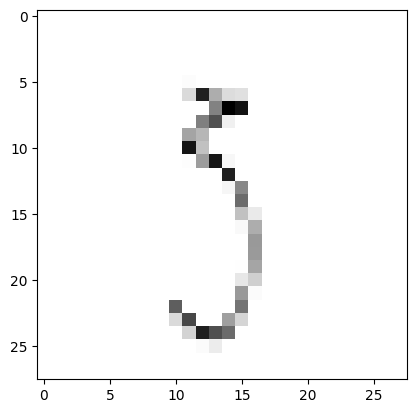

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


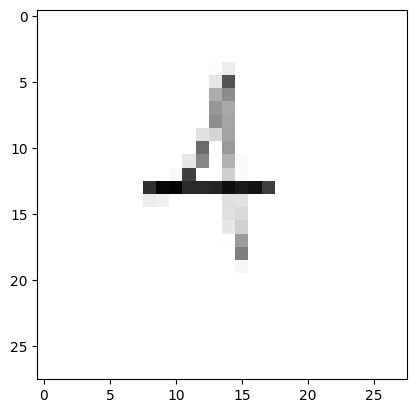

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


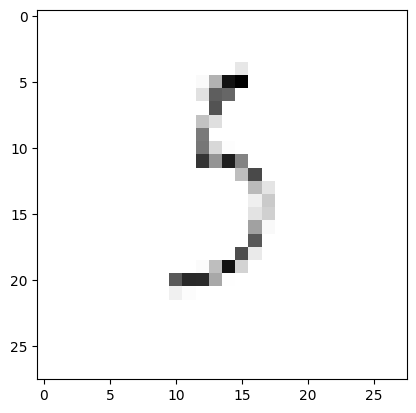

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


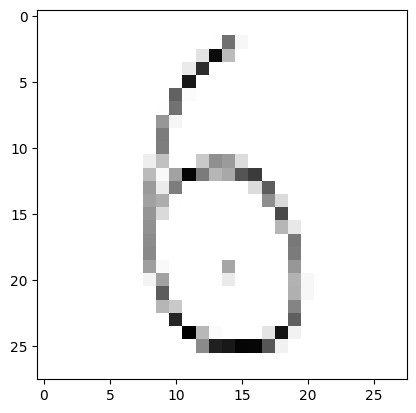

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


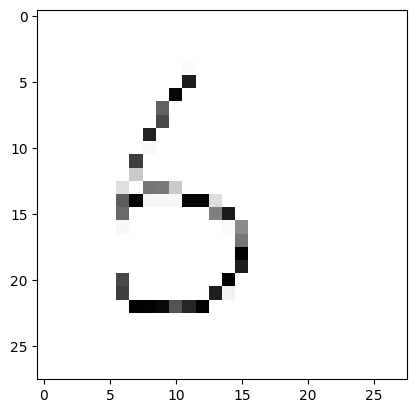

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


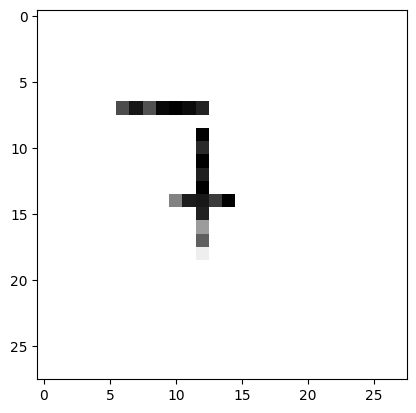

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


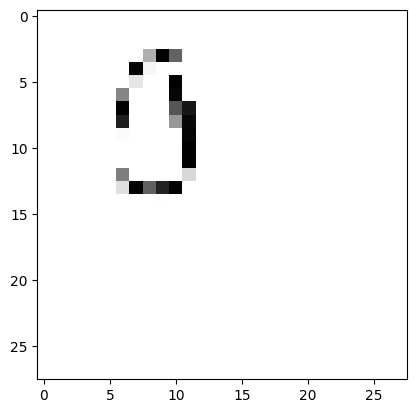

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


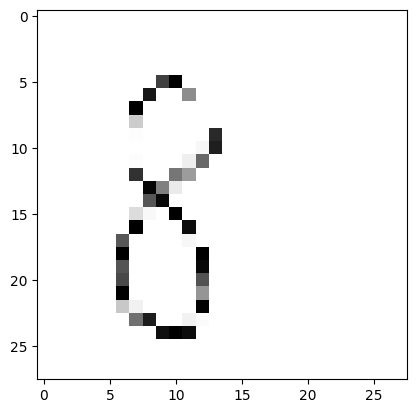

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


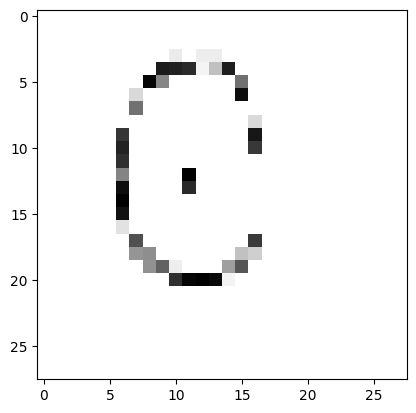

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


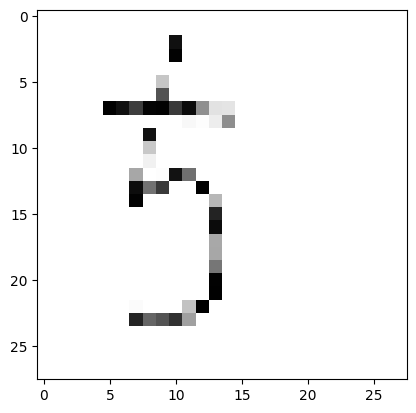

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


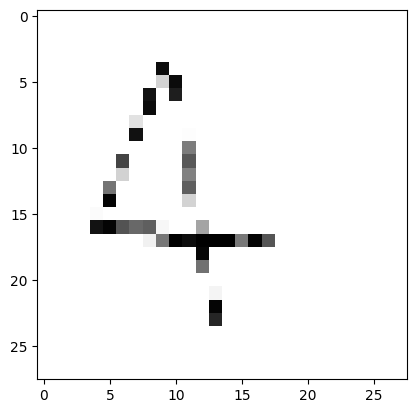

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


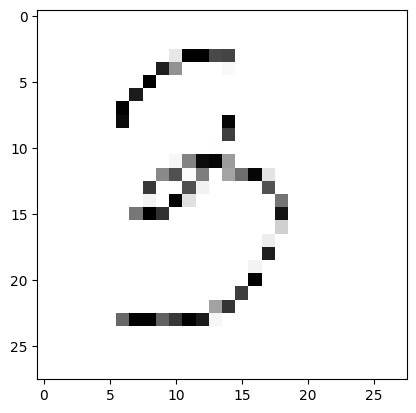

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


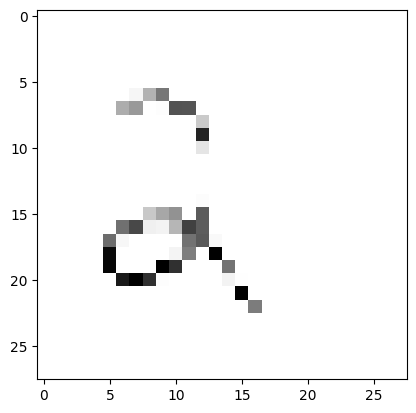

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


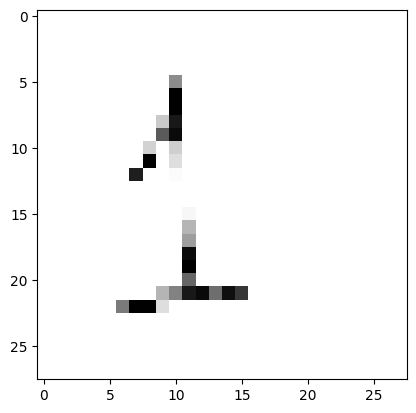

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


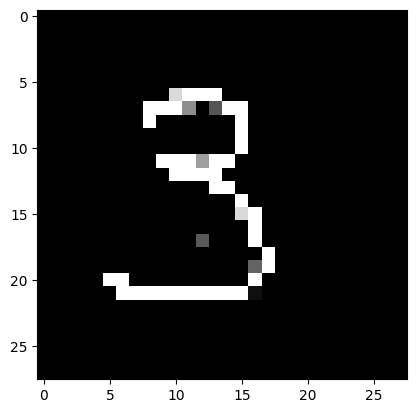

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


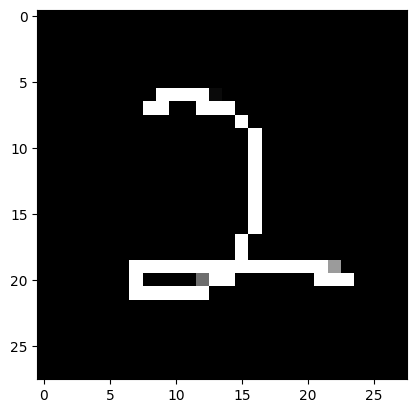

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


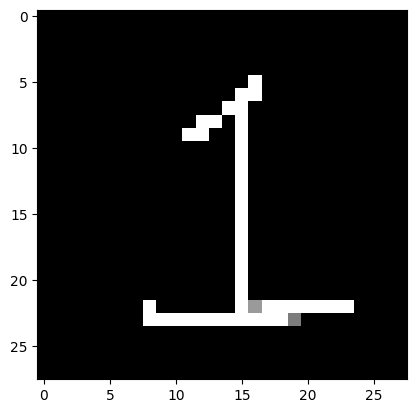

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


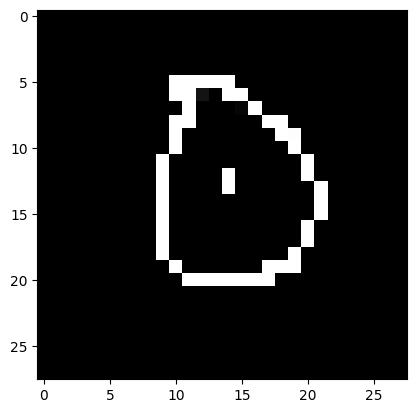

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


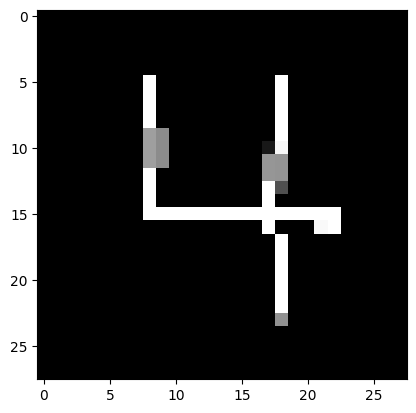

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


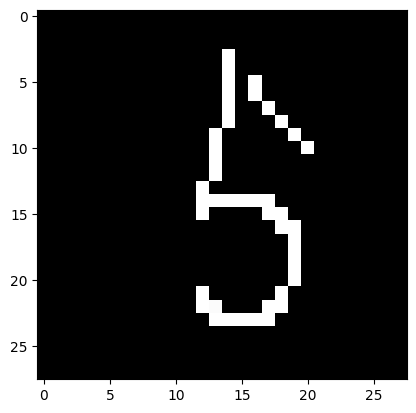

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


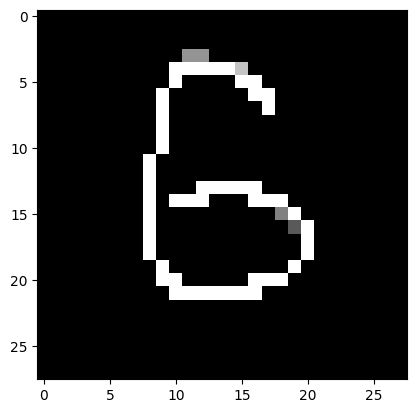

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


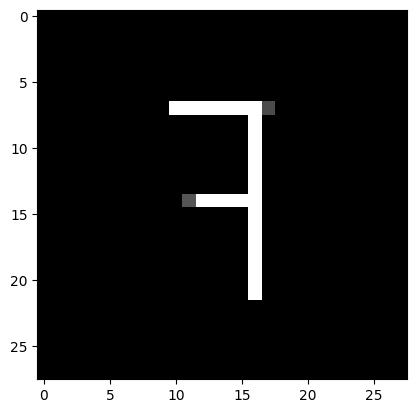

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


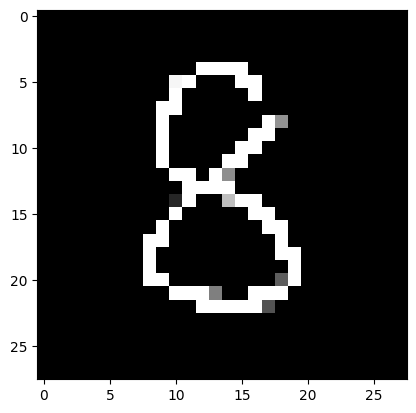

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


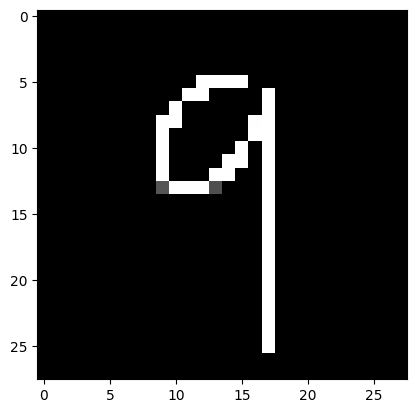

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


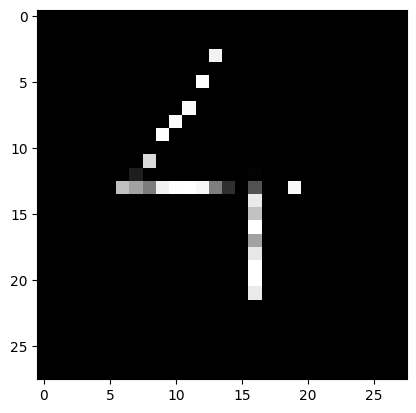

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


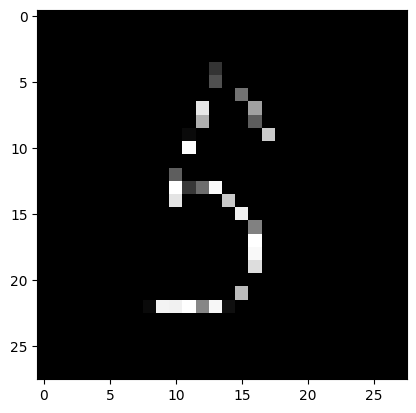

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


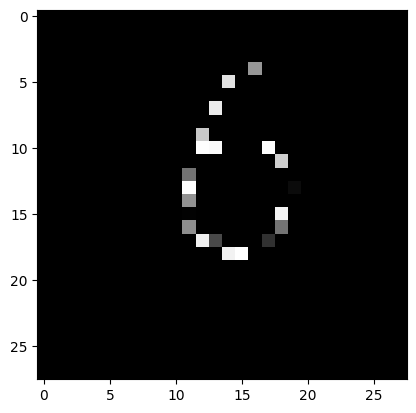

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


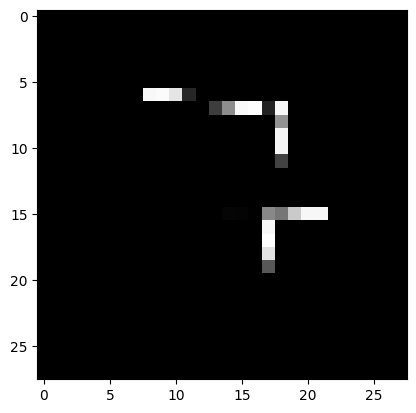

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


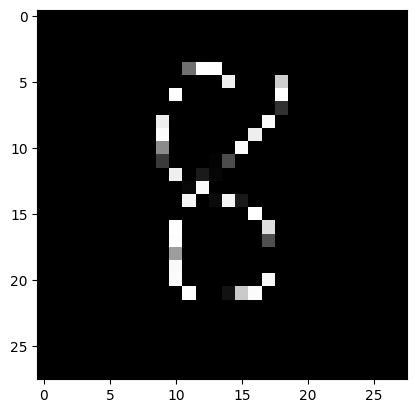

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


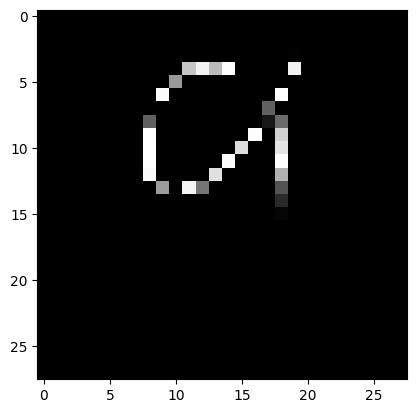

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


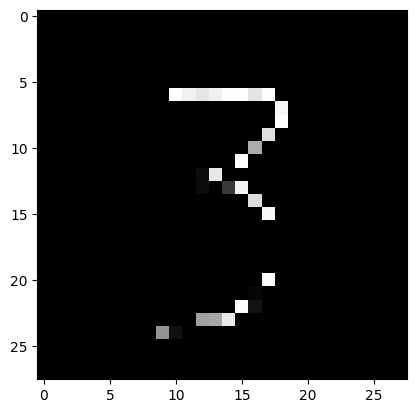

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


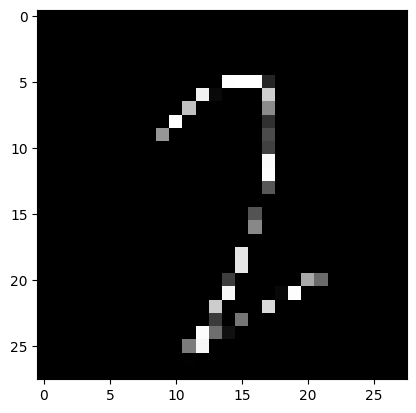

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


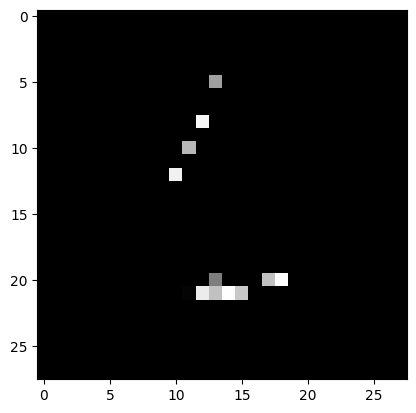

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


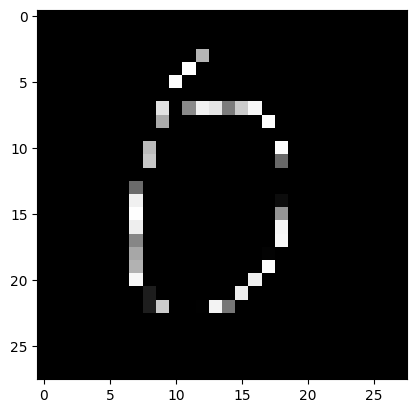

In [47]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

---

# Extra: image_dataset_from_directory
## 이미 내가 이미지 데이터를 클래스별로 정리한 상태라면?
---
## **순서**
1. 구글 드라이브에 my_data/my_mnist2 폴더를 생성합니다.
2. my_mnist2 폴더 안에 손글씨가 폴더별로 구분되어야 한다.
    - ex) 0에 대한 이미지면 my_data/my_mnist2/0/0_1.jpg
    - ex) 1에 대한 이미지면 my_data/my_mnist2/1/1_1.jpg

In [48]:
from keras.utils import image_dataset_from_directory

In [49]:
# idfd_train, idfd_valid = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
#                                                       label_mode='categorical',
#                                                       color_mode='grayscale',
#                                                       image_size=(28,28),
#                                                       seed=2024,
#                                                       validation_split=0.2,
#                                                       subset='both'
#                                                       )

idfd_train = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
                                                      label_mode='categorical',
                                                      color_mode='grayscale',
                                                      image_size=(28,28),
                                                      )

Found 10 files belonging to 10 classes.


In [50]:
keras.utils.clear_session()

model5 = keras.models.load_model('./model1.keras')

# model5.summary()

In [51]:
model5.fit(idfd_train,
        #    validation_data=idfd_valid,
           epochs=1, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1000 - loss: 7.9173


In [52]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [53]:
images.shape

(50, 28, 28, 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  0.  6. 93.  0.  0.  0.  0.  0.  0.]


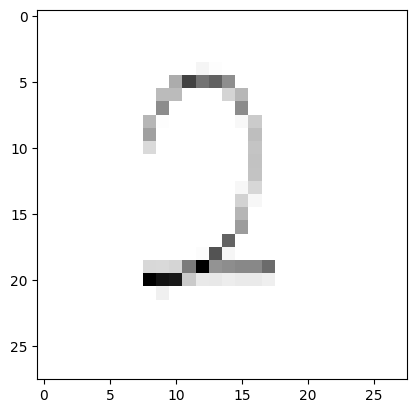

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


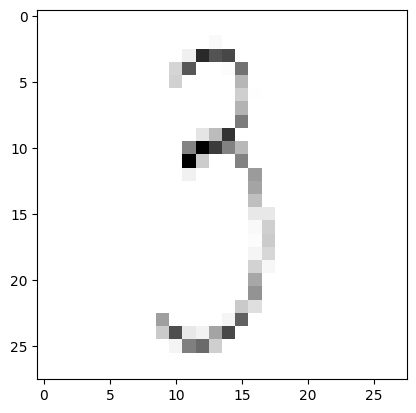

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


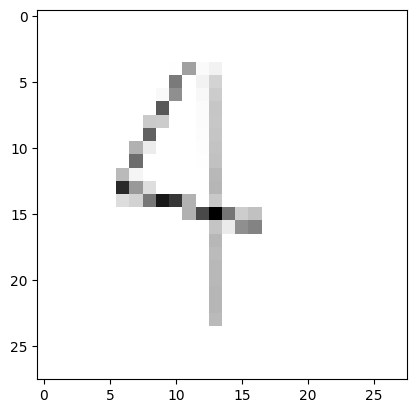

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


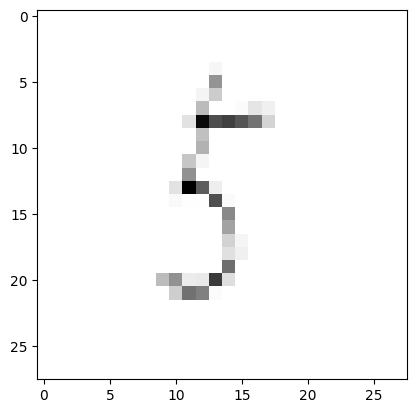

모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]


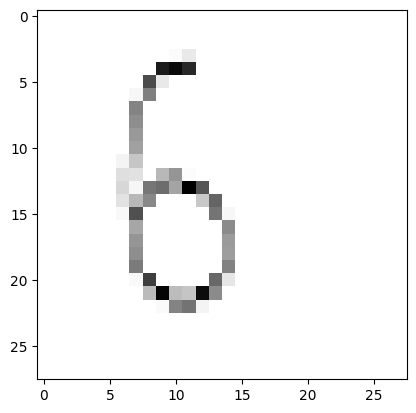

모델의 예측 : 7
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0. 99.  0.  0.]


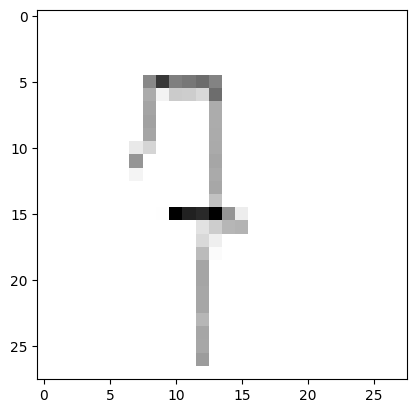

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


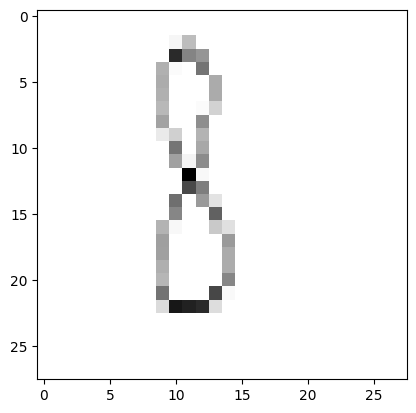

모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 99.]


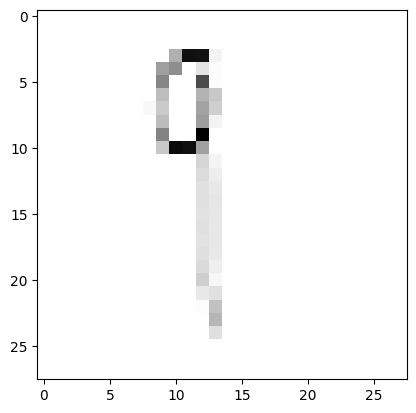

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


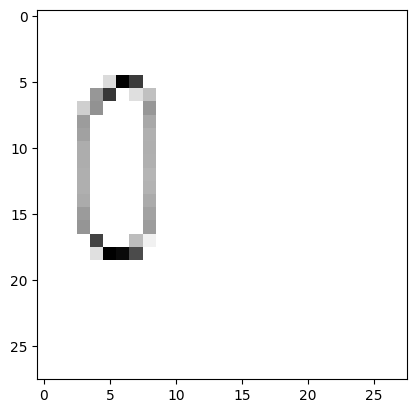

모델의 예측 : 4
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 99.  0.  0.  0.  0.  0.]


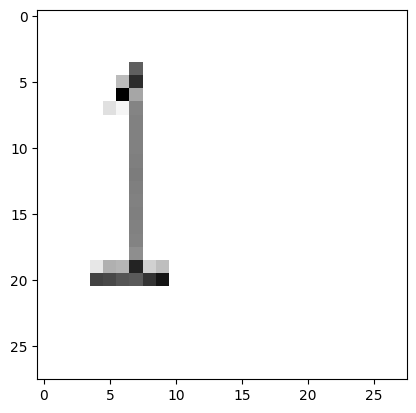

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


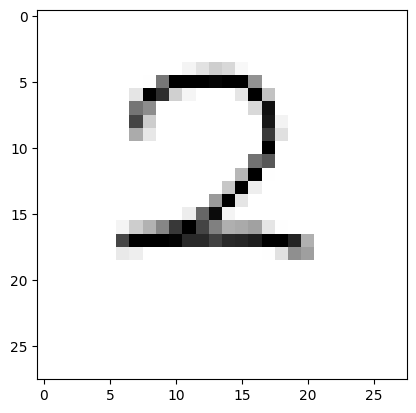

모델의 예측 : 7
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]


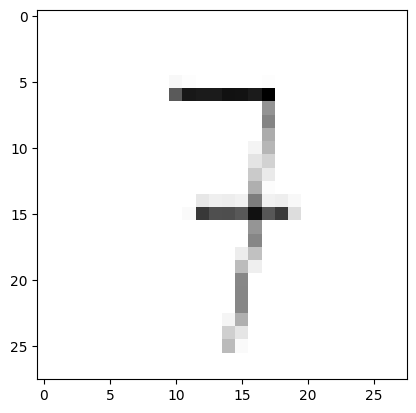

모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]


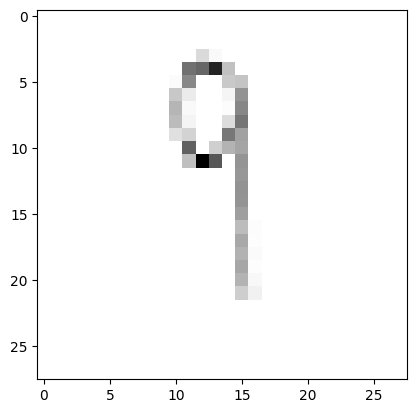

모델의 예측 : 6
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0. 89. 10.  0.  0.]


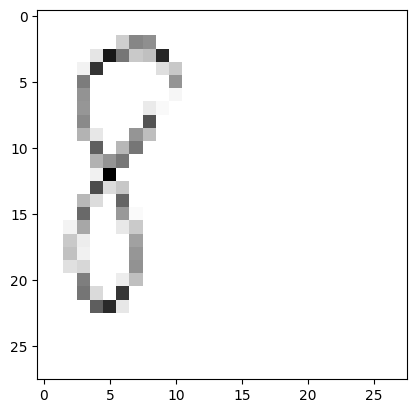

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


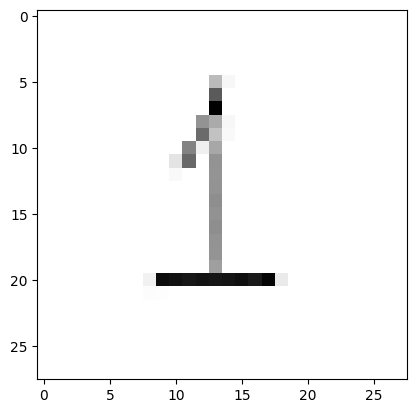

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


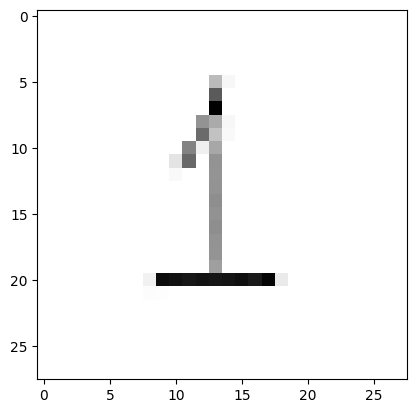

모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 99.]


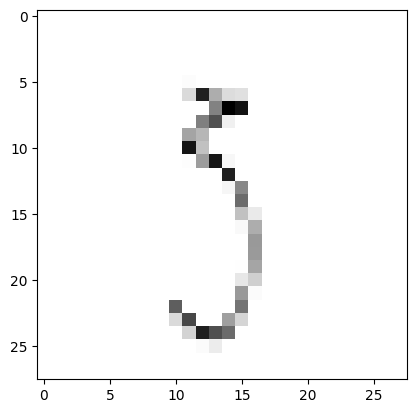

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


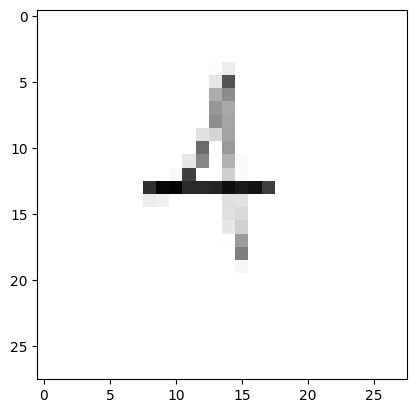

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


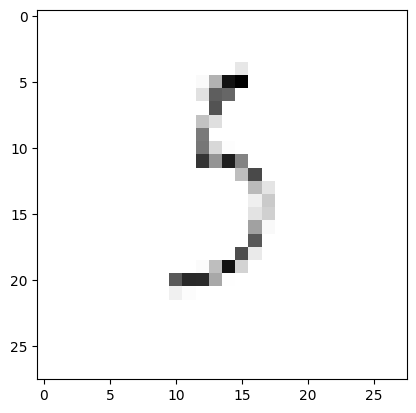

모델의 예측 : 6
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]


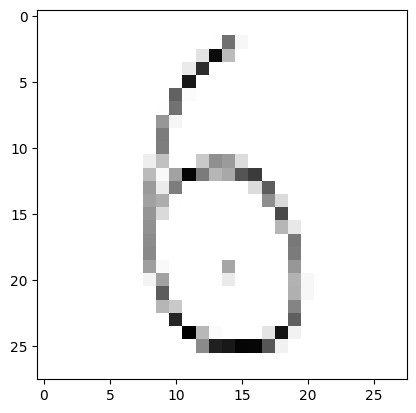

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


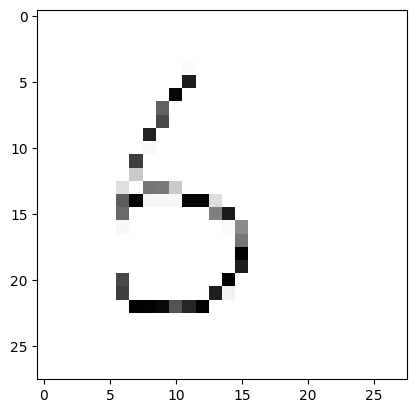

모델의 예측 : 7
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]


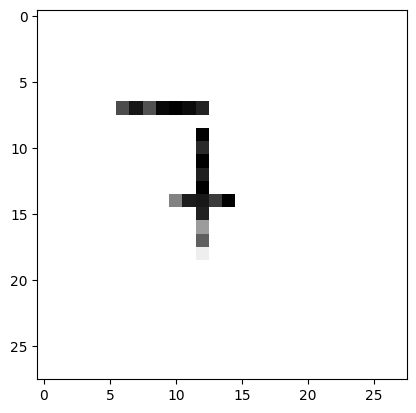

모델의 예측 : 7
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]


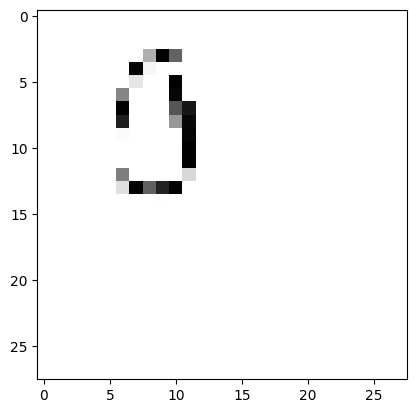

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


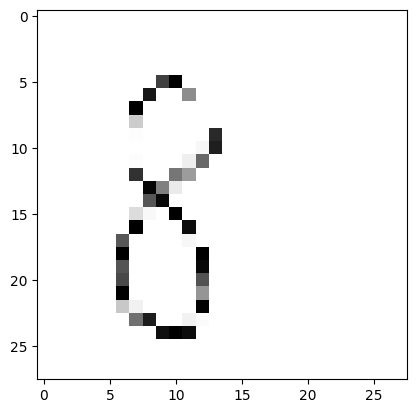

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


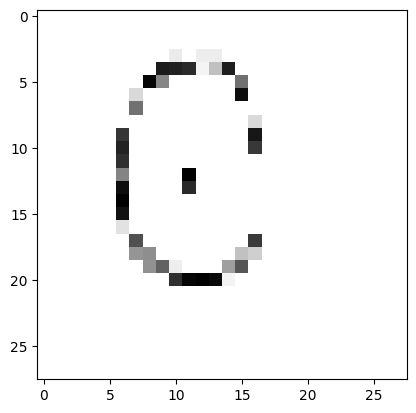

모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  0.  0. 99.  0.  0.  0.  0.  0.  0.]


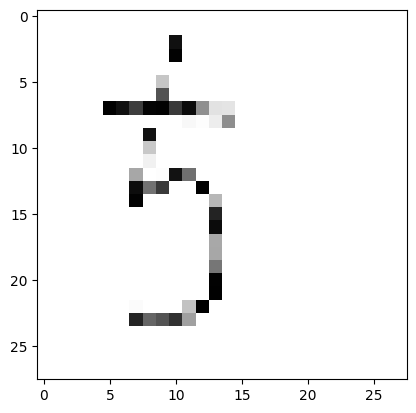

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


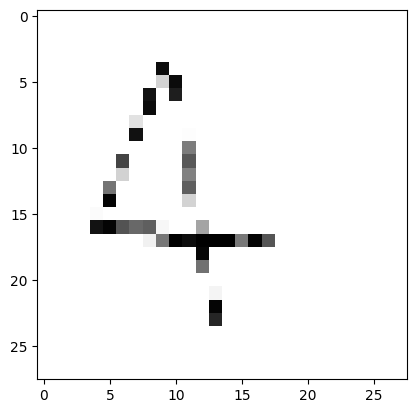

모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  0.  0. 82.  0. 17.  0.  0.  0.  0.]


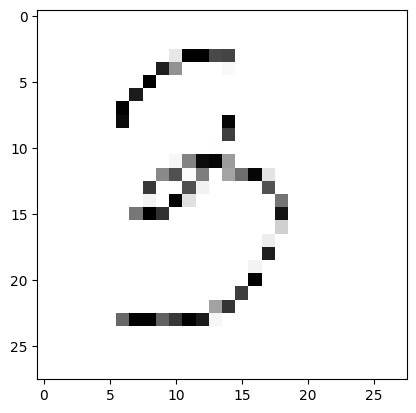

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


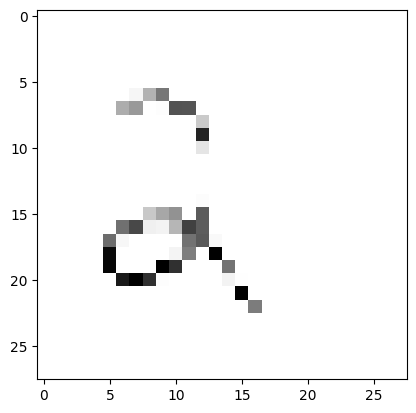

모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]


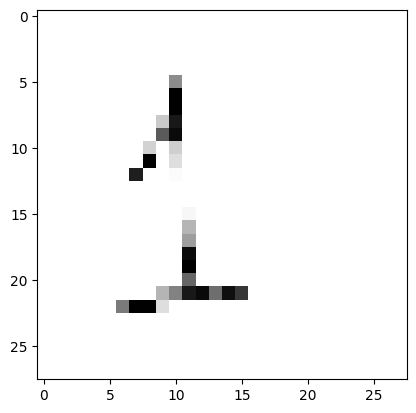

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


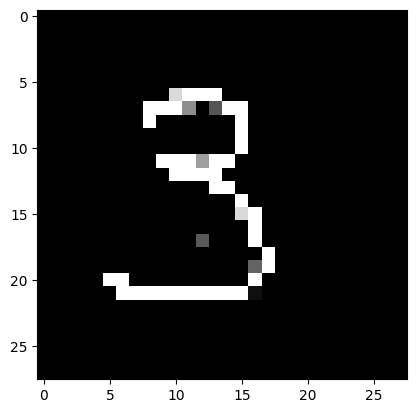

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


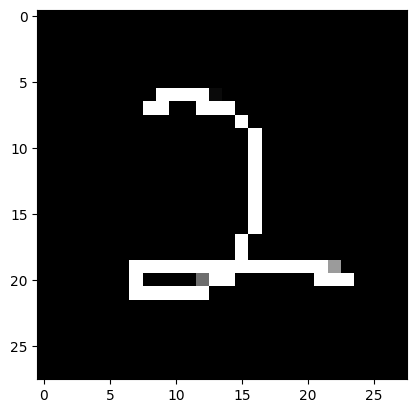

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


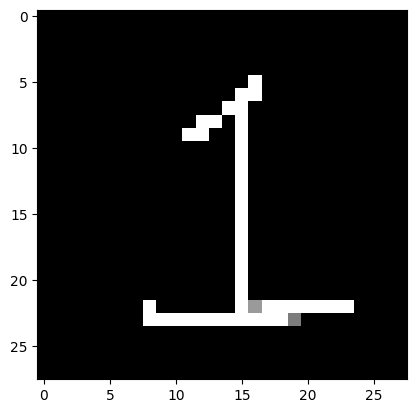

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


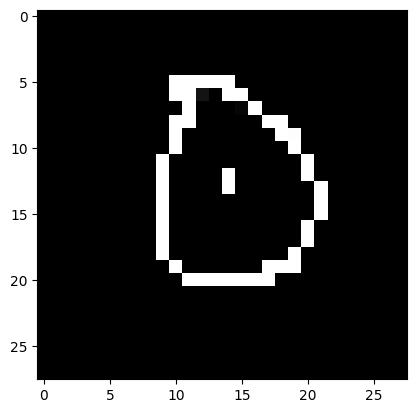

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


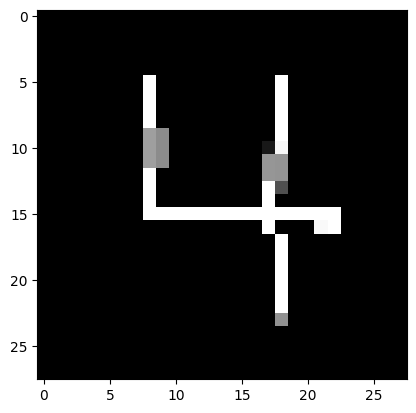

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


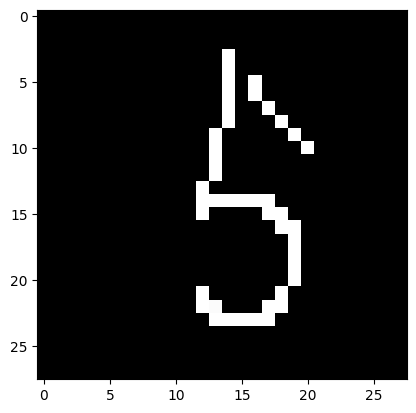

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


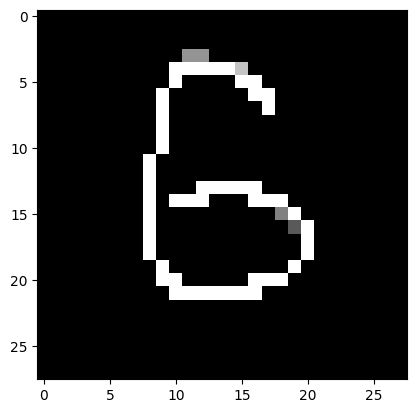

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


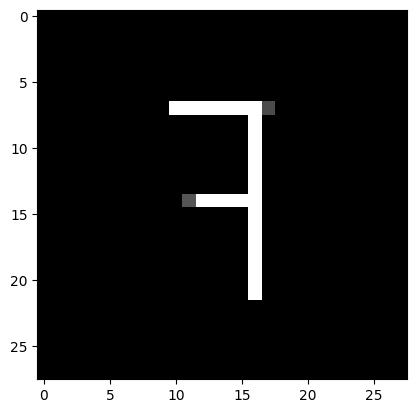

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


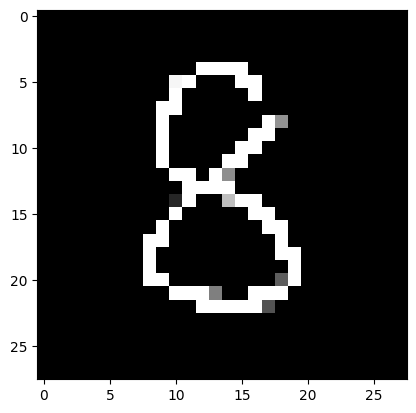

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


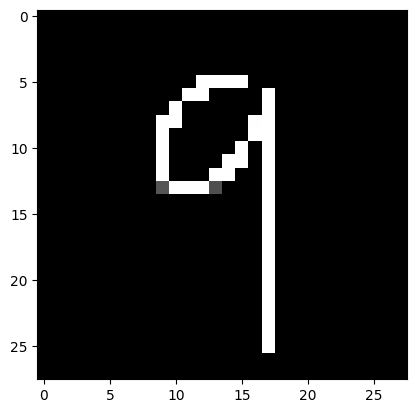

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


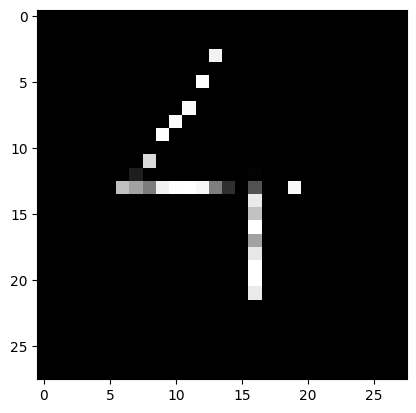

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


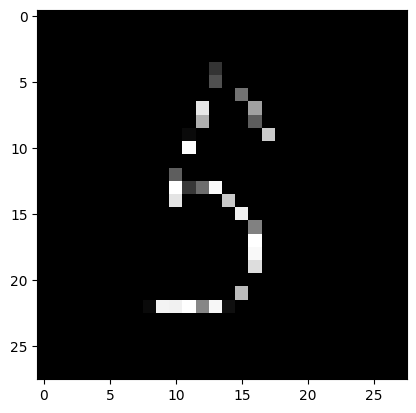

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


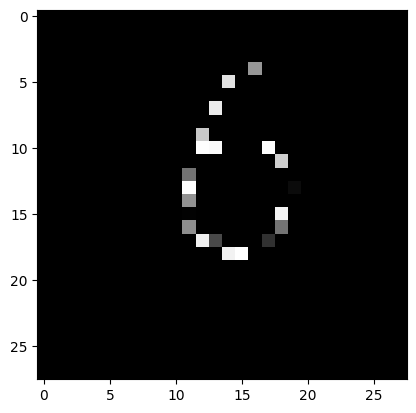

모델의 예측 : 8
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0. 99.  0.]


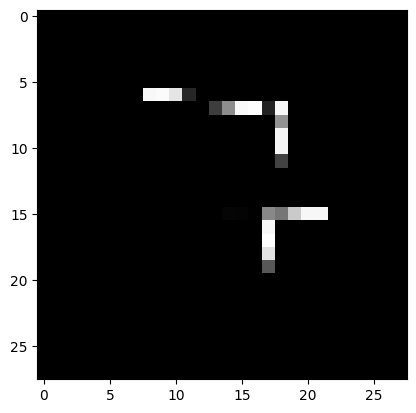

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


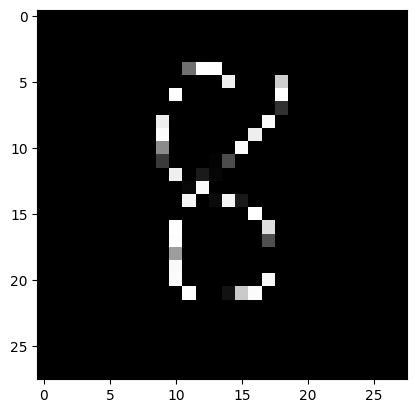

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


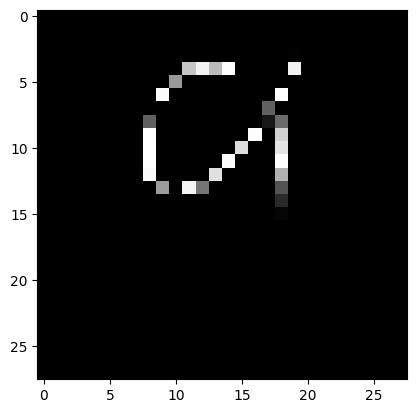

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


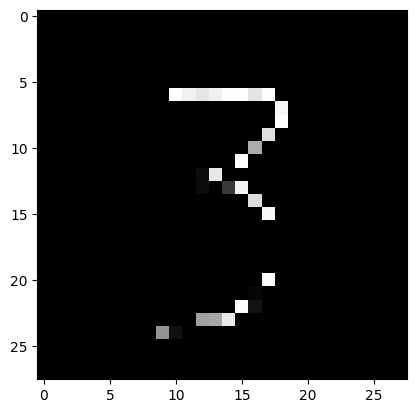

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


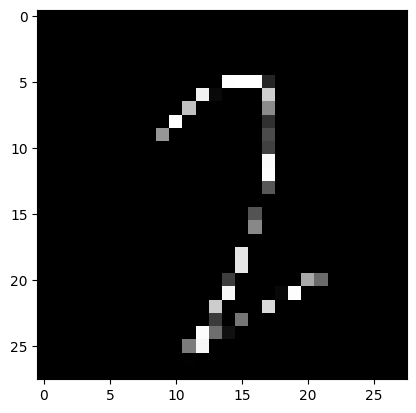

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


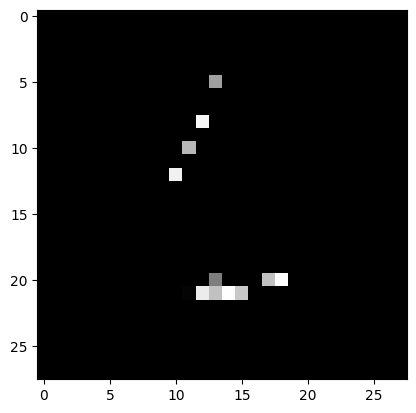

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


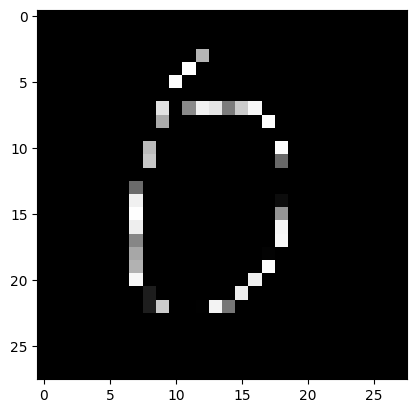

In [54]:
pred = model5.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()